# Financial Text Classification Using FinBERT With Pytorch
@Author: Zoumana Keita  
The code of this notebook is highly inspired of this course on coursera:   
https://www.coursera.org/projects/sentiment-analysis-bert

## Imports

In [2]:
"""
To install a library, run the following command: 
!pip install library_name
"""
import warnings
warnings.filterwarnings('ignore') # to avoid warnings

import random
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

"""
Sklearn Libraries
"""
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

"""
Transformer Libraries
"""
from transformers import BertTokenizer,  AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup

"""
Pytorch Libraries
"""
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


In [99]:
def show_headline_distribution(sequence_lengths, figsize = (15,8)):
    
    # Get the percentage of reviews with length > 512
    len_512_plus = [rev_len for rev_len in sequence_lengths if rev_len > 512]
    percent = (len(len_512_plus)/len(sequence_lengths))*100
    
    print("Maximum Sequence Length is {}".format(max(sequence_lengths)))
    
    # Configure the plot size
    plt.figure(figsize = figsize)

    sns.set(style='darkgrid')
    
    # Increase information on the figure
    sns.set(font_scale=1.3)
    
    # Plot the result
    sns.distplot(sequence_lengths, kde = False, rug = False)
    plt.title('Headlines Lengths Distribution')
    plt.xlabel('Headlines Length')
    plt.ylabel('Number of Headlines')

In [6]:
# Load the dataset
"""
Link to dataset
https://www.kaggle.com/shivamburnwal/text-classification-financial-news/data
Download it and rename it FinancialNewsHeadline.csv
"""
financial_data = pd.read_csv("./data/FinancialNewsHeadline.csv", 
                             encoding='latin-1', 
                             names=['sentiment', 'NewsHeadline'])

In [7]:
financial_data.head()

,sentiment,NewsHeadline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [8]:
financial_data.shape

(4846, 2)

In [114]:
financial_data.sentiment.value_counts()

neutral     2879
positive    1363
negative     604
Name: sentiment, dtype: int64

In [52]:
def show_random_headlines(total_number, df):
    
    # Get the random number of reviews
    n_reviews = df.sample(total_number)
    
    # Print each one of the reviews
    for val in list(n_reviews.index):
        print("Reviews #°{}".format(val))
        print(" - Sentiment: {}".format(df.iloc[val]["sentiment"]))
        print(" - News Headline: {}".format(df.iloc[val]["NewsHeadline"]))
        print("")
        

In [55]:
# Show 3 random headlines
show_random_headlines(5, financial_data)

Reviews #°3902
 - Sentiment: neutral
 - News Headline: The segments through which the company operates are Frozen Food business , Seafoods , Vegetable Oil business , Grain Trading and Other business operations .

Reviews #°821
 - Sentiment: positive
 - News Headline: All of Raisio 's divisions recorded an operating profit .

Reviews #°4337
 - Sentiment: neutral
 - News Headline: The company operates a U.S. division in Lisle , Ill. .

Reviews #°1944
 - Sentiment: positive
 - News Headline: Finnish OKO bank has signed a cooperation agreement with Raiffeisen concerning Finnish companies ' investments in Russia .

Reviews #°4785
 - Sentiment: negative
 - News Headline: The announcement pushed Freenet shares down 6.3 % , or EUR0 .71 , in Frankfurt trade to EUR10 .65 as investors gave up hope United Internet AG and Drillisch would pursue their own takeover and breakup of Freenet .



Text(0, 0.5, 'Number of News')

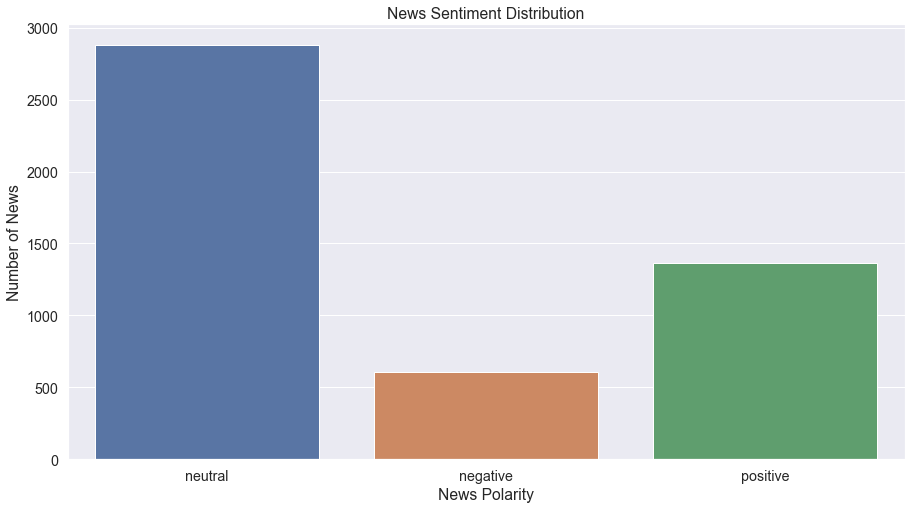

In [9]:
# Configure the plot size
plt.figure(figsize = (15,8))

sns.set(style='darkgrid')
    
# Increase information on the figure
sns.set(font_scale=1.3)
sns.countplot(x='sentiment', data = financial_data)
plt.title('News Sentiment Distribution')
plt.xlabel('News Polarity')
plt.ylabel('Number of News')

In [92]:
def get_headlines_len(df):
    
    headlines_sequence_lengths = []
    
    print("Encoding in progress...")
    for headline in tqdm(df.NewsHeadline):
        encoded_headline = finbert_tokenizer.encode(headline, 
                                         add_special_tokens = True)
        
        # record the length of the encoded review
        headlines_sequence_lengths.append(len(encoded_headline))
    print("End of Task.")
    
    return headlines_sequence_lengths

## Data Preparation

In [84]:
def encode_sentiments_values(df):
    
    possible_sentiments = df.sentiment.unique()
    sentiment_dict = {}
    
    for index, possible_sentiment in enumerate(possible_sentiments):
        sentiment_dict[possible_sentiment] = index
    
    # Encode all the sentiment values
    df['label'] = df.sentiment.replace(sentiment_dict)
    
    return df, sentiment_dict

In [61]:
financial_data.head()

,sentiment,NewsHeadline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [85]:
# Encode the sentiment column
financial_data, sentiment_dict = encode_sentiments_values(financial_data)

financial_data.head()

,sentiment,NewsHeadline,label,data_type
0,neutral,"According to Gran , the company has no plans t...",0,train
1,neutral,Technopolis plans to develop in stages an area...,0,train
2,negative,The international electronic industry company ...,1,train
3,positive,With the new production plant the company woul...,2,train
4,positive,According to the company 's updated strategy f...,2,train


In [65]:
# Create training and validation data
X_train, X_val, y_train, y_val = train_test_split(financial_data.index.values, 
                                                  financial_data.label.values, 
                                                  test_size = 0.15, 
                                                  random_state = 2022, 
                                                  stratify = financial_data.label.values)

In [67]:
# Create the data type columns
financial_data.loc[X_train, 'data_type'] = 'train'
financial_data.loc[X_val, 'data_type'] = 'val'

# Vizualiez the number of sentiment occurence on each type of data
financial_data.groupby(['sentiment', 'label', 'data_type']).count()

NewsHeadline
sentiment label data_type              
negative  1     train               513
                val                  91
neutral   0     train              2447
                val                 432
positive  2     train              1159
                val                 204

In [101]:
# Get the FinBERT Tokenizer
finbert_tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert", 
                                          do_lower_case=True)

# Encode the Training and Validation Data
encoded_data_train = finbert_tokenizer.batch_encode_plus(
    financial_data[financial_data.data_type=='train'].NewsHeadline.values, 
    return_tensors='pt',
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=150 # the maximum lenght observed in the headlines
)

encoded_data_val = finbert_tokenizer.batch_encode_plus(
    financial_data[financial_data.data_type=='val'].NewsHeadline.values, 
    return_tensors='pt',
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=150 # the maximum lenght observed in the headlines
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(financial_data[financial_data.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
sentiments_val = torch.tensor(financial_data[financial_data.data_type=='val'].label.values)


dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, sentiments_val)



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [86]:
len(sentiment_dict)

3

In [103]:
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert",
                                                          num_labels=len(sentiment_dict),
                                                          output_attentions=False,
                                                          output_hidden_states=False)

In [93]:
headlines_sequence_lengths = get_headlines_len(financial_data)

Encoding in progress...


100%|██████████| 4846/4846 [00:02<00:00, 1638.18it/s]

End of Task.


Maximum Sequence Length is 150


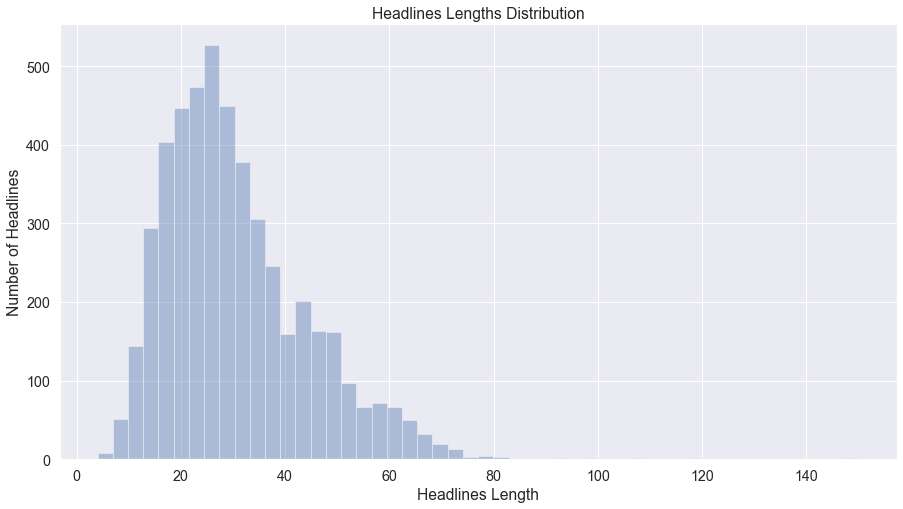

In [100]:
'''
# Show the reviews distribution 
The overall implementation of this function is in my notebook at end of the article
'''
show_headline_distribution(headlines_sequence_lengths)

In [105]:
batch_size = 5

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [107]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

epochs = 3

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [112]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in sentiment_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [110]:
seed_val = 2022
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals


for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'finetuned_finBERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

Epoch 1:   6%|▌         | 48/824 [05:14<1:24:36,  6.54s/it, training_loss=0.210]


Epoch 1:  12%|█▏        | 96/824 [09:58<1:07:26,  5.56s/it, training_loss=0.124]


Epoch 1:  17%|█▋        | 144/824 [14:26<1:02:05,  5.48s/it, training_loss=0.088]


Epoch 1:  23%|██▎       | 193/824 [18:47<54:46,  5.21s/it, training_loss=0.100]


Epoch 1:  29%|██▉       | 242/824 [23:25<1:12:00,  7.42s/it, training_loss=0.025]


Epoch 1:  35%|███▌      | 291/824 [27:47<47:35,  5.36s/it, training_loss=0.088]


Epoch 1:  41%|████▏     | 340/824 [32:11<43:11,  5.36s/it, training_loss=0.379]


Epoch 1:  47%|████▋     | 389/824 [36:35<40:43,  5.62s/it, training_loss=0.024]


Epoch 1:  53%|█████▎    | 438/824 [41:10<35:30,  5.52s/it, training_loss=0.007]


Epoch 1:  59%|█████▉    | 487/824 [45:50<31:35,  5.62s/it, training_loss=0.006]


Epoch 1:  65%|██████▌   | 536/824 [50:25<27:16,  5.68s/it, training_loss=0.006]


Epoch 1:  71%|███████   | 585/824 [54:55<21:41,  5.44s/it, training_loss=0.449]


Epoch 1:  77%|███████▋  | 634/824 [59:22<17:11,  5.43s/it, training_loss=0.319]


Epoch 1:  83%|████████▎ | 682/824 [1:03:50<13:10,  5.57s/it, training_loss=0.125]


Epoch 1:  89%|████████▊ | 730/824 [1:08:16<08:32,  5.45s/it, training_loss=0.314]


Epoch 1:  94%|█████████▍| 778/824 [1:12:51<04:21,  5.68s/it, training_loss=0.004]


  0%|          | 0/3 [1:17:07<?, ?it/s]                                          


Epoch 1
Training loss: 0.4667830017024597


 33%|███▎      | 1/3 [1:20:57<2:41:54, 4857.09s/it]

Validation loss: 0.436770397838052
F1 Score (Weighted): 0.8630187235067245



Epoch 2:   6%|▌         | 48/824 [04:10<1:06:52,  5.17s/it, training_loss=0.002]


Epoch 2:  12%|█▏        | 97/824 [08:14<1:01:42,  5.09s/it, training_loss=0.004]


Epoch 2:  18%|█▊        | 145/824 [12:24<57:44,  5.10s/it, training_loss=0.497]


Epoch 2:  24%|██▎       | 194/824 [16:36<54:57,  5.23s/it, training_loss=0.002]


Epoch 2:  29%|██▉       | 243/824 [21:41<1:18:11,  8.07s/it, training_loss=0.002]


Epoch 2:  35%|███▌      | 291/824 [27:18<59:59,  6.75s/it, training_loss=0.003]  


Epoch 2:  41%|████▏     | 340/824 [32:48<55:02,  6.82s/it, training_loss=0.002]


Epoch 2:  47%|████▋     | 389/824 [38:17<47:44,  6.59s/it, training_loss=0.423]


Epoch 2:  53%|█████▎    | 438/824 [43:40<41:28,  6.45s/it, training_loss=0.628]


Epoch 2:  59%|█████▉    | 487/824 [49:01<36:41,  6.53s/it, training_loss=0.001]


Epoch 2:  65%|██████▌   | 536/824 [54:35<32:26,  6.76s/it, training_loss=0.390]


Epoch 2:  71%|███████   | 585/824 [59:57<25:20,  6.36s/it, training_loss=0.128]


Epoch 2:  77%|███████▋  | 633/824 [1:05:16<20:58,  6.59s/it, training_loss=0.002]


Epoch 2:  83%|████████▎ | 681/824 [1:10:51<17:09,  7.20s/it, training_loss=0.002]


Epoch 2:  88%|████████▊ | 729/824 [1:16:40<12:09,  7.68s/it, training_loss=0.002]


Epoch 2:  94%|█████████▍| 777/824 [1:22:02<04:32,  5.79s/it, training_loss=0.330]


 33%|███▎      | 1/3 [2:47:27<2:41:54, 4857.09s/it]                              


Epoch 2
Training loss: 0.2531573728297145


 67%|██████▋   | 2/3 [2:50:51<1:26:13, 5173.33s/it]

Validation loss: 0.48647358069078334
F1 Score (Weighted): 0.8799487348929824



Epoch 3:   6%|▌         | 48/824 [04:23<1:09:48,  5.40s/it, training_loss=0.001]


Epoch 3:  12%|█▏        | 97/824 [08:37<1:01:21,  5.06s/it, training_loss=0.001]


Epoch 3:  18%|█▊        | 146/824 [12:45<57:11,  5.06s/it, training_loss=0.001]


Epoch 3:  24%|██▎       | 195/824 [16:53<53:52,  5.14s/it, training_loss=0.007]


Epoch 3:  30%|██▉       | 244/824 [21:06<54:34,  5.65s/it, training_loss=0.001]


Epoch 3:  36%|███▌      | 293/824 [25:45<48:22,  5.47s/it, training_loss=0.047]


Epoch 3:  42%|████▏     | 342/824 [30:18<43:57,  5.47s/it, training_loss=0.001]


Epoch 3:  47%|████▋     | 391/824 [34:41<39:08,  5.42s/it, training_loss=0.000]


Epoch 3:  53%|█████▎    | 440/824 [39:05<34:18,  5.36s/it, training_loss=0.001]


Epoch 3:  59%|█████▉    | 489/824 [43:26<29:48,  5.34s/it, training_loss=0.001]


Epoch 3:  65%|██████▌   | 538/824 [47:35<23:56,  5.02s/it, training_loss=0.378]


Epoch 3:  71%|███████   | 587/824 [51:57<21:26,  5.43s/it, training_loss=0.001]


Epoch 3:  77%|███████▋  | 636/824 [56:24<17:24,  5.55s/it, training_loss=0.001]


Epoch 3:  83%|████████▎ | 685/824 [1:00:50<12:32,  5.41s/it, training_loss=0.263]


Epoch 3:  89%|████████▉ | 733/824 [1:05:10<08:14,  5.44s/it, training_loss=0.112]


Epoch 3:  95%|█████████▍| 781/824 [1:09:32<03:53,  5.43s/it, training_loss=0.396]


 67%|██████▋   | 2/3 [4:04:18<1:26:13, 5173.33s/it]                              


Epoch 3
Training loss: 0.15099292005145543


100%|██████████| 3/3 [4:07:48<00:00, 4956.30s/it]  

Validation loss: 0.5383680921386009
F1 Score (Weighted): 0.871166775606992


In [113]:
# Load the best model & Make Predictions

model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert",
                                                          num_labels=len(sentiment_dict),
                                                          output_attentions=False,
                                                          output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('finetuned_finBERT_epoch_1.model', 
                                 map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)

accuracy_per_class(predictions, true_vals)

Class: neutral
Accuracy: 395/432

Class: negative
Accuracy: 73/91

Class: positive
Accuracy: 160/204

